# Size Experiment!

In [158]:
from matplotlib import pyplot as plt
import matplotlib

In [159]:
matplotlib.style.use('ggplot')

In [232]:
# show training process
date = "2023-06-21"
unit = "Paragraph"
model_short = "scibert_scivocab_cased-flat_base-vanila_size_experiment"
model_name = f"/data_ssds/disk06/anonymous/model/gsap/*/{date}/{unit}/{model_short}/*/"
print(model_name)

/data_ssds/disk06/anonymous/model/gsap/*/2023-06-21/Paragraph/scibert_scivocab_cased-flat_base-vanila_size_experiment/*/


In [ ]:
from glob import glob
import json
import pandas as pd
def get_last_epoch(path):
    fns_trainer_state = glob(f"{path}/checkpoint-*/trainer_state.json")
    #print(fns_trainer_state)
    epoch_max = -1
    last_trainer_state = {}
    for fn_trainer_state in fns_trainer_state:
        trainer_state = json.load(open(fn_trainer_state))
        files_epoch = trainer_state["epoch"]
        epoch_max = max(epoch_max, files_epoch)
        if files_epoch == epoch_max:
            last_trainer_state = trainer_state
    return last_trainer_state

def get_all_fold_states(model_folds):
    model_name_folds = glob(model_folds)
    model_name_folds.sort()
    print(f"Data for {len(model_name_folds)} models available")
    eval_epochs = []
    train_loss = []
    for model_fold in model_name_folds:
        fold_idx = int(model_fold[36:37])
        n_docs = (int(model_fold[-2:-1]) + 1) * 8
        trainer_state = get_last_epoch(model_fold)
        for e in trainer_state.get("log_history", []):
            e["fold"] = fold_idx
            e["n_train_docs"] = n_docs
        log_history = [e for e in trainer_state.get("log_history", [])
                       if not "loss" in e]
        for epoch_idx, ele in enumerate(log_history):
            ele["epoch_idx"] = epoch_idx + 1
            
        #for epoch in log_history:
        #    epoch["epoch"] = int(epoch["epoch"])
        eval_epochs.extend(log_history)
        train_loss.extend([e for e in trainer_state.get("log_history", [])
                           if "loss" in e])
        
    eval_epochs = pd.DataFrame(eval_epochs)
    train_loss = pd.DataFrame(train_loss)
    return eval_epochs, train_loss

In [255]:
print(model_name)
eval_stats, train_stats = get_all_fold_states(model_name)
#train_history = pd.DataFrame(eval_epochs).set_index("epoch")
cols = [c for c in eval_stats.columns  if c.endswith("_f1")]
cols_ordered = eval_stats[cols].iloc[-1].sort_values(ascending=False).index

/data_ssds/disk06/anonymous/model/gsap/*/2023-06-21/Paragraph/scibert_scivocab_cased-flat_base-vanila_size_experiment/*/
Data for 20 models available


# mean fold performance for each size

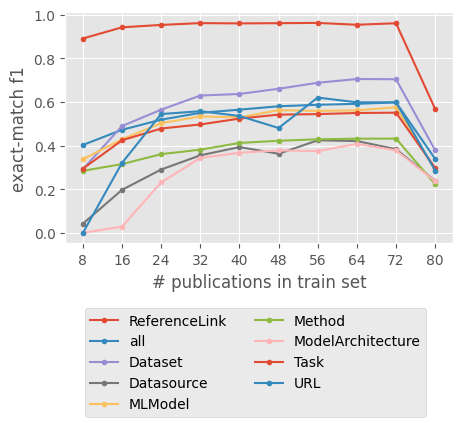

In [256]:
title = ""#Increase the amount of publications in the train set"
plot_params = dict(
    title=title, 
    xticks=[i * 8 for i in range(1,11)],
    logx=False,
    style='.-',
    figsize=(5,3)
)

plot_data = eval_stats\
                .groupby(["n_train_docs", "fold"])\
                .apply(lambda x: x.sort_values("eval_f1", ascending=False)\
                .iloc[0])\
                .reset_index(drop=True)\
                .groupby("n_train_docs")\
                .mean()\
                [cols_ordered]
plot_data.columns = [c[5:-3] if c[5:-3] else "all" for c in plot_data.columns]

ax = plot_data\
    .plot(**plot_params)
ax.legend(bbox_to_anchor=(0.95,-.25), ncol=2);
ax.set_xlabel("# publications in train set")
ax.set_ylabel("exact-match f1")
plt.savefig("size_experiment_f1.png", bbox_inches='tight')

# Boxplot of the overall performance in a 10-fold run

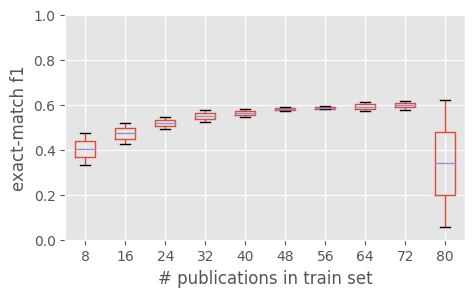

In [257]:
ax = eval_stats\
    .groupby(["n_train_docs", "fold"])\
    .apply(lambda x: x.sort_values("eval_f1", ascending=False).iloc[0])\
    [cols_ordered]\
    .reset_index()\
    [["eval_f1","n_train_docs"]]\
    .boxplot(by="n_train_docs",figsize=(5,3))
ax.set_xlabel("# publications in train set")
ax.set_title("")
plt.suptitle('')
ax.set_ylabel("exact-match f1")
ax.set_ylim((0,1))
plt.savefig("size_experiment_boxplot.png", bbox_inches='tight')

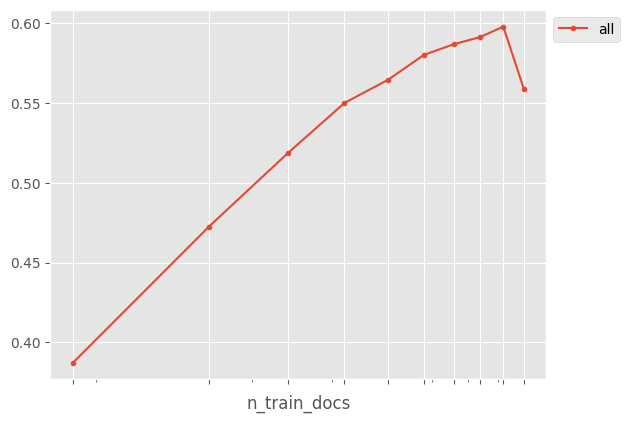

In [246]:
ax = plot_data[["all"]]\
    .plot(xticks=xticks, title=title, style='.-', logx=True)\
    .legend(bbox_to_anchor=(1,1));
plt.savefig("size_experiment_f1.png", bbox_inches='tight')

In [805]:
#show_corpus_stats(fn_stats, tagset="flat_plus")